## Rate Model of 1 Excitatory and 2 Inhibitory populations
3 Wilson-Cowan style populations with feedforward input from thalamus and recurrent connections.

Following the 2 population model in Natan et al 2015, 4 population model in Litwin-Kumar et al 2016, and 3 population model in Park and Geffen 2019

Rough outline:
0. Make general model with 3x3 weight matrix
1. Implement all of Park population and stimulation pattern

1. Reproduce one iso-frequency unit 
3. Reproduce three iso-frquency unit model outcome 
4. Introduce 
5. Extend to reproduce experimental findings in Natan  

# other ideas:
learning rule Hebbian - pca on the inputs  
- SSA not really a long term plasticiy phenomenon but rather STP
depression of different feed forward inputs  


In [15]:
from IPython.display import HTML, IFrame, Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch
import time
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy import stats
from scipy import optimize
from scipy.signal import decimate
from scipy import signal
from scipy import integrate
import seaborn as sns

import gc
import time

#%matplotlib inline
%matplotlib notebook

from matplotlib import rcParams, cm
rcParams['grid.linewidth'] = 0
rcParams['pdf.fonttype'] = 42
# import custom functions


# import custom functions
from helper_functions import *
import helper_functions

# reload(helper_functions)
# from helper_functions import *
figure_directory = "/home/auguste/Documents/CNE_PhD/organisation/Cajal/Project/code/1E3I/figures/park/"
fontsize = 20

from scipy import integrate

import seaborn as sns
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size']=14
#plt.rcParams['font.family']='SansSerif'

In [16]:
### network architectures
def network(r, t, J, T):    
    drdt = (-r + transfer_func(mu(t) + np.dot(J,r)))/T
    return drdt

def linear_network(r, t, W, T):    
    # linearized network
    # r is a 4-D vector that represents the firing rate of the units
    drdt = (np.dot(W,r)-r + mu(t))/T
    return drdt

def network_TC_adapt(y, t, W, T, T_adapt, g0):
    # network with thalamocortical adaptation
    # y represents the firing rate of the units and the adaptation variables    
    r,g = y[:3], y[3:]
    
    thalamic = generic_constant_input(t, thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    
    # does not depress
#    mu = thalamic + opto
    # depressing synapse
    mu = thalamic*np.hstack((g,[0,0])) + opto
    
    drdt = (np.dot(W,r)-r + mu)/T

    # synaptic adaptation
    # T_g (recovery), T_r (depression)
    r_pre = thalamic[:2]
    T_g, T_r = T_adapt[0,:], T_adapt[1,:]
    dgdt = (g0-g)/T_g - (g*r_pre)/T_r

    dydt = np.hstack((drdt,dgdt))
    return dydt

### transfer functions
def transfer_func(curr_input):
    # transfer function from current to firing rate    
    return curr_input**2

### input functions
def generic_constant_input(t,v=0,t_onset=0.1):
    if t<=t_onset:
        return np.zeros_like(v)
    else:
        return v
    
def mu(t):
    # time-varying input to the network    
    thalamic = generic_constant_input(t,thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    total_drive = thalamic + opto
    return total_drive

### plotting
def plot_rates(t,r,savetitle="rates"):
    figsize=(5, 3)
    labels = ['E','PV','SOM','VIP']

    xlabel = r"time [s]"
    ylabel =r"firing rate [Hz]"

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    axiswidth = 1.5
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(axiswidth)
    ax.xaxis.set_tick_params(width=axiswidth)
    ax.yaxis.set_tick_params(width=axiswidth)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
    #plt.plot(x,x_nl, lw = 3, c = "darkblue", label="k = 10")
   # plt.subplot(2,1,1)
    for i in range(len(r0)):
        plt.plot(t,r[:,i],color=color[i],label=labels[i])
        
    #plt.ylabel('Firing Rate (Hz)')
    #plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

    # for q in steps:
    #     plt.axhline(y=q, c="grey")
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(fontsize = fontsize, frameon=False)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.tight_layout()

    save_fig(figure_directory, savetitle)
    
def plot_currents(t,r,W, savetitle="total_currents"):
    labels = ['E','PV','SOM','VIP']
    Ie, Ii = return_EI(r,W)
    plt.plot(t,Ie, 'midnightblue', label='E Total')
    plt.plot(t,Ii, 'darkred', label='I Total')
    plt.xlabel('time [s]')
    plt.ylabel('Current')
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.tight_layout()

    save_fig(figure_directory, savetitle)

### analysis
def return_EI(r, W):
    curr = W[0,:]*r
    Ie, Ii=curr[:,0], -curr[:,1:].sum(1)
    return Ie-Ie[0],Ii-Ii[0]


In [45]:
def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
    # transfer function from 9,rx,r to firing rate
    if r < r_min:
        r = r_min
    elif r > r_max:
        r = gain
    else:
        r = gain*r
    return r

def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
    # transfer function from 9,rx,r to firing rate
    if r < r_min:
        r = r_min
    elif r > 1/gain:
        r = 1
    else:
        r = gain*r
    return r


# def transfer_func_park_vector(r,gain = 3, r_max = 1, r_min = 0 ):
#     # transfer function from 9,rx,r to firing rate
#     for i in range(len)
#     if r < r_min:
#         r = r_min
#     elif r > r_max:
#         r = gain
#     else:
#         r = gain*r
#     return r

# def threshold_linear(r,rth, r_max = 1, r_min = 0 ):
#     # transfer function from 9,rx,r to firing rate
#     r = r - rth
#     for i in range(len(rr)):
#         if rr[i] < r_min:
#             r = r_min
#         elif r > r_max:
#             r = gain
#         else:
#             r = gain*r
#     return r

def stimulus(dur=0.1,pause=0.3, T = 10):
    ''' generate input stimulus 
    input:
    dur tone duration: 100 ms
    pause inter stimulus pause 300 ms
    T total run time 
    output:
    numpy array with spiketimes'''
    N_pulse = int(np.floor(T/(dur+pause)))-1
    print(N_pulse)
    stim = np.zeros((N_pulse,2))
    for i in range(N_pulse):
        stim[i,0] = (i+1)*(dur+pause)
    stim[:,1] = stim[:,0] + dur
    return stim
# forward euler 
# get thalamic input right
# model g ffw adaptation

def thalamic_input_current(stimtimes, t, tau = 0.01, q = 5.):
    I = np.zeros(len(t))
    dt = t[1]-t[0]
    counter = 0
    for i in range(len(t)-1):
        didt = -i/tau
        I[i+1] = I[i] + (-I[i]/tau)*dt
        if t[i] >= stimtimes[counter]:
            I[i+1] += q
            counter += 1
    return I
def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.1, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        g[i+1] = g[i] + dgdt*dt
    return g

<IPython.core.display.Javascript object>


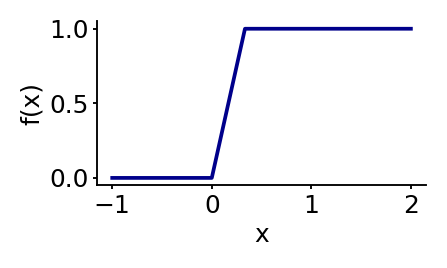

In [46]:
x = np.linspace(-1,2,100)
x_nl = np.copy(x)
for i in range(len(x)):
    x_nl[i] = transfer_func_park(x[i])

figsize=(5, 3)
ylabel = r"f(x)"
xlabel =r"x"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(x,x_nl, lw = 3, c = "darkblue", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "nonlinearity_xy")

# Parameter initialisation

In [47]:
color = ["midnightblue","darkgreen","darkorange","purple"]

r0 = np.array([4,3,3]).T
T, dt = 1, 0.0001
t = np.arange(0,T,dt)
tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
uth = 1.
pth = 1.
sth = 0.7
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
I = thalamic_input_current(stim[:,0],t)
# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E
q = 1.3

24


In [48]:
external_input = np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T
external_input[2] = 0 # no input to SOM

In [49]:
r = np.zeros((3,len(t)))
# r[0,0]=4
# r[1,0]=9
# r[2,0]=5

dt = t[1]-t[0]
print(dt)
print(W)
for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    for k in range(len(total_input)):
        total_input[k] = transfer_func_park(total_input[k])
    
    drdt = -r[:,i] + total_input
#     print(np.dot(W,r[:,i]))
#     print(q*mu[:,i])
#     print(thr)
    print(drdt)

    r[:,i+1] = r[:,i] + drdt*dt/taus # integration step
    print(r[:,i+1])
    print(r[:,i])


0.0001
[[ 1.1 -2.  -1. ]
 [ 1.  -2.  -2. ]
 [ 6.   0.   0. ]]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0.

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]

[0.50335033 0.34586279 0.48459199]
[0.50671339 0.34935635 0.47938585]
[-0.39995298 -0.34586279  0.51540801]
[0.4993508  0.34240416 0.48974607]
[0.50335033 0.34586279 0.48459199]
[-0.46426264 -0.34240416  0.51025393]
[0.49470818 0.33898012 0.49484861]
[0.4993508  0.34240416 0.48974607]
[-0.49470818 -0.33898012  0.50515139]
[0.4897611  0.33559032 0.49990013]
[0.49470818 0.33898012 0.49484861]
[-0.4897611  -0.33559032  0.50009987]
[0.48486349 0.33223442 0.50490113]
[0.4897611  0.33559032 0.49990013]
[-0.48486349 -0.33223442  0.49509887]
[0.48001485 0.32891207 0.50985212]
[0.48486349 0.33223442 0.50490113]
[-0.48001485 -0.32891207  0.49014788]
[0.4752147  0.32562295 0.51475359]
[0.48001485 0.32891207 0.50985212]
[-0.4752147  -0.32562295  0.48524641]
[0.47046256 0.32236672 0.51960606]
[0.4752147  0.32562295 0.51475359]
[-0.47046256 -0.32236672  0.48039394]
[0.46575793 0.31914305 0.52441   ]
[0.47046256 0.32236672 0.51960606]
[-0.46575793 -0.31914305  0.47559   ]
[0.46110035 0.31595162 0.529

[0.00422116 0.00289239 0.02543148]
[-0.00417894 -0.00286346 -0.02517717]
[0.00413715 0.00283483 0.0249254 ]
[0.00417894 0.00286346 0.02517717]
[-0.00413715 -0.00283483 -0.0249254 ]
[0.00409578 0.00280648 0.02467614]
[0.00413715 0.00283483 0.0249254 ]
[-0.00409578 -0.00280648 -0.02467614]
[0.00405482 0.00277842 0.02442938]
[0.00409578 0.00280648 0.02467614]
[-0.00405482 -0.00277842 -0.02442938]
[0.00401428 0.00275063 0.02418509]
[0.00405482 0.00277842 0.02442938]
[-0.00401428 -0.00275063 -0.02418509]
[0.00397413 0.00272313 0.02394324]
[0.00401428 0.00275063 0.02418509]
[-0.00397413 -0.00272313 -0.02394324]
[0.00393439 0.00269589 0.0237038 ]
[0.00397413 0.00272313 0.02394324]
[-0.00393439 -0.00269589 -0.0237038 ]
[0.00389505 0.00266894 0.02346677]
[0.00393439 0.00269589 0.0237038 ]
[-0.00389505 -0.00266894 -0.02346677]
[0.0038561  0.00264225 0.0232321 ]
[0.00389505 0.00266894 0.02346677]
[-0.0038561  -0.00264225 -0.0232321 ]
[0.00381754 0.00261582 0.02299978]
[0.0038561  0.00264225 0.023

[-3.06673805e-05 -2.10136658e-05 -1.84763866e-04]
[3.03607067e-05 2.08035292e-05 1.82916228e-04]
[3.06673805e-05 2.10136658e-05 1.84763866e-04]
[-3.03607067e-05 -2.08035292e-05 -1.82916228e-04]
[3.00570997e-05 2.05954939e-05 1.81087065e-04]
[3.03607067e-05 2.08035292e-05 1.82916228e-04]
[-3.00570997e-05 -2.05954939e-05 -1.81087065e-04]
[2.97565287e-05 2.03895389e-05 1.79276195e-04]
[3.00570997e-05 2.05954939e-05 1.81087065e-04]
[-2.97565287e-05 -2.03895389e-05 -1.79276195e-04]
[2.94589634e-05 2.01856436e-05 1.77483433e-04]
[2.97565287e-05 2.03895389e-05 1.79276195e-04]
[-2.94589634e-05 -2.01856436e-05 -1.77483433e-04]
[2.91643738e-05 1.99837871e-05 1.75708598e-04]
[2.94589634e-05 2.01856436e-05 1.77483433e-04]
[-2.91643738e-05 -1.99837871e-05 -1.75708598e-04]
[2.88727300e-05 1.97839493e-05 1.73951512e-04]
[2.91643738e-05 1.99837871e-05 1.75708598e-04]
[-2.88727300e-05 -1.97839493e-05 -1.73951512e-04]
[2.85840027e-05 1.95861098e-05 1.72211997e-04]
[2.88727300e-05 1.97839493e-05 1.739515

[-6.40068718e-07 -4.38582947e-07 -3.85626581e-06]
[6.33668031e-07 4.34197118e-07 3.81770315e-06]
[6.40068718e-07 4.38582947e-07 3.85626581e-06]
[-6.33668031e-07 -4.34197118e-07 -3.81770315e-06]
[6.27331350e-07 4.29855147e-07 3.77952612e-06]
[6.33668031e-07 4.34197118e-07 3.81770315e-06]
[-6.27331350e-07 -4.29855147e-07 -3.77952612e-06]
[6.21058037e-07 4.25556595e-07 3.74173086e-06]
[6.27331350e-07 4.29855147e-07 3.77952612e-06]
[-6.21058037e-07 -4.25556595e-07 -3.74173086e-06]
[6.14847456e-07 4.21301029e-07 3.70431355e-06]
[6.21058037e-07 4.25556595e-07 3.74173086e-06]
[-6.14847456e-07 -4.21301029e-07 -3.70431355e-06]
[6.08698982e-07 4.17088019e-07 3.66727041e-06]
[6.14847456e-07 4.21301029e-07 3.70431355e-06]
[-6.08698982e-07 -4.17088019e-07 -3.66727041e-06]
[6.02611992e-07 4.12917139e-07 3.63059771e-06]
[6.08698982e-07 4.17088019e-07 3.66727041e-06]
[-6.02611992e-07 -4.12917139e-07 -3.63059771e-06]
[5.96585872e-07 4.08787967e-07 3.59429173e-06]
[6.02611992e-07 4.12917139e-07 3.630597

[2.51628172e-08 1.72418714e-08 1.51600147e-07]
[-2.49111890e-08 -1.70694527e-08 -1.50084145e-07]
[2.46620771e-08 1.68987582e-08 1.48583304e-07]
[2.49111890e-08 1.70694527e-08 1.50084145e-07]
[-2.46620771e-08 -1.68987582e-08 -1.48583304e-07]
[2.44154564e-08 1.67297706e-08 1.47097471e-07]
[2.46620771e-08 1.68987582e-08 1.48583304e-07]
[-2.44154564e-08 -1.67297706e-08 -1.47097471e-07]
[2.41713018e-08 1.65624729e-08 1.45626496e-07]
[2.44154564e-08 1.67297706e-08 1.47097471e-07]
[-2.41713018e-08 -1.65624729e-08 -1.45626496e-07]
[2.39295888e-08 1.63968482e-08 1.44170231e-07]
[2.41713018e-08 1.65624729e-08 1.45626496e-07]
[-2.39295888e-08 -1.63968482e-08 -1.44170231e-07]
[2.36902929e-08 1.62328797e-08 1.42728529e-07]
[2.39295888e-08 1.63968482e-08 1.44170231e-07]
[-2.36902929e-08 -1.62328797e-08 -1.42728529e-07]
[2.34533900e-08 1.60705509e-08 1.41301244e-07]
[2.36902929e-08 1.62328797e-08 1.42728529e-07]
[-2.34533900e-08 -1.60705509e-08 -1.41301244e-07]
[2.32188561e-08 1.59098454e-08 1.398882

[3.51331400e-10 2.40736591e-10 2.11669033e-09]
[3.54880202e-10 2.43168274e-10 2.13807104e-09]
[-3.51331400e-10 -2.40736591e-10 -2.11669033e-09]
[3.47818086e-10 2.38329225e-10 2.09552343e-09]
[3.51331400e-10 2.40736591e-10 2.11669033e-09]
[-3.47818086e-10 -2.38329225e-10 -2.09552343e-09]
[3.44339905e-10 2.35945933e-10 2.07456819e-09]
[3.47818086e-10 2.38329225e-10 2.09552343e-09]
[-3.44339905e-10 -2.35945933e-10 -2.07456819e-09]
[3.40896506e-10 2.33586473e-10 2.05382251e-09]
[3.44339905e-10 2.35945933e-10 2.07456819e-09]
[-3.40896506e-10 -2.33586473e-10 -2.05382251e-09]
[3.37487541e-10 2.31250609e-10 2.03328429e-09]
[3.40896506e-10 2.33586473e-10 2.05382251e-09]
[-3.37487541e-10 -2.31250609e-10 -2.03328429e-09]
[3.34112666e-10 2.28938103e-10 2.01295144e-09]
[3.37487541e-10 2.31250609e-10 2.03328429e-09]
[-3.34112666e-10 -2.28938103e-10 -2.01295144e-09]
[3.30771539e-10 2.26648722e-10 1.99282193e-09]
[3.34112666e-10 2.28938103e-10 2.01295144e-09]
[-3.30771539e-10 -2.26648722e-10 -1.992821

[4.75970739e-12 3.26140997e-12 2.86761348e-11]
[-4.71211031e-12 -3.22879587e-12 -2.83893735e-11]
[4.66498921e-12 3.19650791e-12 2.81054798e-11]
[4.71211031e-12 3.22879587e-12 2.83893735e-11]
[-4.66498921e-12 -3.19650791e-12 -2.81054798e-11]
[4.61833932e-12 3.16454283e-12 2.78244250e-11]
[4.66498921e-12 3.19650791e-12 2.81054798e-11]
[-4.61833932e-12 -3.16454283e-12 -2.78244250e-11]
[4.57215593e-12 3.13289740e-12 2.75461807e-11]
[4.61833932e-12 3.16454283e-12 2.78244250e-11]
[-4.57215593e-12 -3.13289740e-12 -2.75461807e-11]
[4.52643437e-12 3.10156843e-12 2.72707189e-11]
[4.57215593e-12 3.13289740e-12 2.75461807e-11]
[-4.52643437e-12 -3.10156843e-12 -2.72707189e-11]
[4.48117002e-12 3.07055274e-12 2.69980117e-11]
[4.52643437e-12 3.10156843e-12 2.72707189e-11]
[-4.48117002e-12 -3.07055274e-12 -2.69980117e-11]
[4.43635832e-12 3.03984721e-12 2.67280316e-11]
[4.48117002e-12 3.07055274e-12 2.69980117e-11]
[-4.43635832e-12 -3.03984721e-12 -2.67280316e-11]
[4.39199474e-12 3.00944874e-12 2.646075

[5.22134787e-14 3.57773169e-14 3.14574118e-13]
[-5.16913439e-14 -3.54195438e-14 -3.11428377e-13]
[5.11744305e-14 3.50653483e-14 3.08314093e-13]
[5.16913439e-14 3.54195438e-14 3.11428377e-13]
[-5.11744305e-14 -3.50653483e-14 -3.08314093e-13]
[5.06626862e-14 3.47146948e-14 3.05230952e-13]
[5.11744305e-14 3.50653483e-14 3.08314093e-13]
[-5.06626862e-14 -3.47146948e-14 -3.05230952e-13]
[5.01560593e-14 3.43675479e-14 3.02178643e-13]
[5.06626862e-14 3.47146948e-14 3.05230952e-13]
[-5.01560593e-14 -3.43675479e-14 -3.02178643e-13]
[4.96544987e-14 3.40238724e-14 2.99156856e-13]
[5.01560593e-14 3.43675479e-14 3.02178643e-13]
[-4.96544987e-14 -3.40238724e-14 -2.99156856e-13]
[4.91579537e-14 3.36836337e-14 2.96165288e-13]
[4.96544987e-14 3.40238724e-14 2.99156856e-13]
[-4.91579537e-14 -3.36836337e-14 -2.96165288e-13]
[4.86663742e-14 3.33467974e-14 2.93203635e-13]
[4.91579537e-14 3.36836337e-14 2.96165288e-13]
[-4.86663742e-14 -3.33467974e-14 -2.93203635e-13]
[4.81797104e-14 3.30133294e-14 2.902715

[-4.73209768e-16 -3.24249145e-16 -2.85097927e-15]
[4.68477670e-16 3.21006654e-16 2.82246948e-15]
[4.73209768e-16 3.24249145e-16 2.85097927e-15]
[-4.68477670e-16 -3.21006654e-16 -2.82246948e-15]
[4.63792893e-16 3.17796587e-16 2.79424478e-15]
[4.68477670e-16 3.21006654e-16 2.82246948e-15]
[-4.63792893e-16 -3.17796587e-16 -2.79424478e-15]
[4.59154964e-16 3.14618621e-16 2.76630234e-15]
[4.63792893e-16 3.17796587e-16 2.79424478e-15]
[-4.59154964e-16 -3.14618621e-16 -2.76630234e-15]
[4.54563415e-16 3.11472435e-16 2.73863931e-15]
[4.59154964e-16 3.14618621e-16 2.76630234e-15]
[-4.54563415e-16 -3.11472435e-16 -2.73863931e-15]
[4.50017780e-16 3.08357711e-16 2.71125292e-15]
[4.54563415e-16 3.11472435e-16 2.73863931e-15]
[-4.50017780e-16 -3.08357711e-16 -2.71125292e-15]
[4.45517603e-16 3.05274134e-16 2.68414039e-15]
[4.50017780e-16 3.08357711e-16 2.71125292e-15]
[-4.45517603e-16 -3.05274134e-16 -2.68414039e-15]
[4.41062427e-16 3.02221392e-16 2.65729899e-15]
[4.45517603e-16 3.05274134e-16 2.684140

[-8.84281952e-18 -6.05920855e-18 -5.32759399e-17]
[8.75439132e-18 5.99861646e-18 5.27431805e-17]
[8.84281952e-18 6.05920855e-18 5.32759399e-17]
[-8.75439132e-18 -5.99861646e-18 -5.27431805e-17]
[8.66684741e-18 5.93863030e-18 5.22157487e-17]
[8.75439132e-18 5.99861646e-18 5.27431805e-17]
[-8.66684741e-18 -5.93863030e-18 -5.22157487e-17]
[8.58017893e-18 5.87924400e-18 5.16935912e-17]
[8.66684741e-18 5.93863030e-18 5.22157487e-17]
[-8.58017893e-18 -5.87924400e-18 -5.16935912e-17]
[8.49437714e-18 5.82045156e-18 5.11766553e-17]
[8.58017893e-18 5.87924400e-18 5.16935912e-17]
[-8.49437714e-18 -5.82045156e-18 -5.11766553e-17]
[8.40943337e-18 5.76224704e-18 5.06648887e-17]
[8.49437714e-18 5.82045156e-18 5.11766553e-17]
[-8.40943337e-18 -5.76224704e-18 -5.06648887e-17]
[8.32533904e-18 5.70462457e-18 5.01582399e-17]
[8.40943337e-18 5.76224704e-18 5.06648887e-17]
[-8.32533904e-18 -5.70462457e-18 -5.01582399e-17]
[8.24208565e-18 5.64757832e-18 4.96566575e-17]
[8.32533904e-18 5.70462457e-18 5.015823

[0.01419584 0.0104519  0.07669672]
[-0.01405388 -0.01034738 -0.07592975]
[0.01391334 0.01024391 0.07517045]
[0.01405388 0.01034738 0.07592975]
[-0.01391334 -0.01024391 -0.07517045]
[0.01377421 0.01014147 0.07441875]
[0.01391334 0.01024391 0.07517045]
[-0.01377421 -0.01014147 -0.07441875]
[0.01363647 0.01004005 0.07367456]
[0.01377421 0.01014147 0.07441875]
[-0.01363647 -0.01004005 -0.07367456]
[0.0135001  0.00993965 0.07293782]
[0.01363647 0.01004005 0.07367456]
[-0.0135001  -0.00993965 -0.07293782]
[0.0133651  0.00984026 0.07220844]
[0.0135001  0.00993965 0.07293782]
[-0.0133651  -0.00984026 -0.07220844]
[0.01323145 0.00974185 0.07148635]
[0.0133651  0.00984026 0.07220844]
[-0.01323145 -0.00974185 -0.07148635]
[0.01309914 0.00964444 0.07077149]
[0.01323145 0.00974185 0.07148635]
[-0.01309914 -0.00964444 -0.07077149]
[0.01296814 0.00954799 0.07006377]
[0.01309914 0.00964444 0.07077149]
[-0.01296814 -0.00954799 -0.07006377]
[0.01283846 0.00945251 0.06936314]
[0.01296814 0.00954799 0.070

[-1.08450226e-04 -7.98481080e-05 -5.85930569e-04]
[1.07365724e-04 7.90496269e-05 5.80071263e-04]
[1.08450226e-04 7.98481080e-05 5.85930569e-04]
[-1.07365724e-04 -7.90496269e-05 -5.80071263e-04]
[1.06292067e-04 7.82591306e-05 5.74270551e-04]
[1.07365724e-04 7.90496269e-05 5.80071263e-04]
[-1.06292067e-04 -7.82591306e-05 -5.74270551e-04]
[1.05229146e-04 7.74765393e-05 5.68527845e-04]
[1.06292067e-04 7.82591306e-05 5.74270551e-04]
[-1.05229146e-04 -7.74765393e-05 -5.68527845e-04]
[1.04176855e-04 7.67017739e-05 5.62842567e-04]
[1.05229146e-04 7.74765393e-05 5.68527845e-04]
[-1.04176855e-04 -7.67017739e-05 -5.62842567e-04]
[1.03135086e-04 7.59347562e-05 5.57214141e-04]
[1.04176855e-04 7.67017739e-05 5.62842567e-04]
[-1.03135086e-04 -7.59347562e-05 -5.57214141e-04]
[1.02103735e-04 7.51754086e-05 5.51642000e-04]
[1.03135086e-04 7.59347562e-05 5.57214141e-04]
[-1.02103735e-04 -7.51754086e-05 -5.51642000e-04]
[1.01082698e-04 7.44236546e-05 5.46125580e-04]
[1.02103735e-04 7.51754086e-05 5.516420

[1.30231513e-06 9.58849073e-07 7.03609638e-06]
[-1.28929198e-06 -9.49260583e-07 -6.96573541e-06]
[1.27639906e-06 9.39767977e-07 6.89607806e-06]
[1.28929198e-06 9.49260583e-07 6.96573541e-06]
[-1.27639906e-06 -9.39767977e-07 -6.89607806e-06]
[1.26363507e-06 9.30370297e-07 6.82711728e-06]
[1.27639906e-06 9.39767977e-07 6.89607806e-06]
[-1.26363507e-06 -9.30370297e-07 -6.82711728e-06]
[1.25099872e-06 9.21066594e-07 6.75884610e-06]
[1.26363507e-06 9.30370297e-07 6.82711728e-06]
[-1.25099872e-06 -9.21066594e-07 -6.75884610e-06]
[1.23848873e-06 9.11855928e-07 6.69125764e-06]
[1.25099872e-06 9.21066594e-07 6.75884610e-06]
[-1.23848873e-06 -9.11855928e-07 -6.69125764e-06]
[1.22610384e-06 9.02737369e-07 6.62434507e-06]
[1.23848873e-06 9.11855928e-07 6.69125764e-06]
[-1.22610384e-06 -9.02737369e-07 -6.62434507e-06]
[1.21384280e-06 8.93709995e-07 6.55810162e-06]
[1.22610384e-06 9.02737369e-07 6.62434507e-06]
[-1.21384280e-06 -8.93709995e-07 -6.55810162e-06]
[1.20170438e-06 8.84772895e-07 6.492520

[1.50225095e-08 1.10605482e-08 8.11630167e-08]
[-1.48722844e-08 -1.09499428e-08 -8.03513866e-08]
[1.47235616e-08 1.08404433e-08 7.95478727e-08]
[1.48722844e-08 1.09499428e-08 8.03513866e-08]
[-1.47235616e-08 -1.08404433e-08 -7.95478727e-08]
[1.45763259e-08 1.07320389e-08 7.87523940e-08]
[1.47235616e-08 1.08404433e-08 7.95478727e-08]
[-1.45763259e-08 -1.07320389e-08 -7.87523940e-08]
[1.44305627e-08 1.06247185e-08 7.79648700e-08]
[1.45763259e-08 1.07320389e-08 7.87523940e-08]
[-1.44305627e-08 -1.06247185e-08 -7.79648700e-08]
[1.42862571e-08 1.05184713e-08 7.71852213e-08]
[1.44305627e-08 1.06247185e-08 7.79648700e-08]
[-1.42862571e-08 -1.05184713e-08 -7.71852213e-08]
[1.41433945e-08 1.04132866e-08 7.64133691e-08]
[1.42862571e-08 1.05184713e-08 7.71852213e-08]
[-1.41433945e-08 -1.04132866e-08 -7.64133691e-08]
[1.40019605e-08 1.03091537e-08 7.56492354e-08]
[1.41433945e-08 1.04132866e-08 7.64133691e-08]
[-1.40019605e-08 -1.03091537e-08 -7.56492354e-08]
[1.38619409e-08 1.02060622e-08 7.489274

τu
du(t) dtwpss
= −u(t) + f (weeu −wepp −wess + qI(t))  
, τp
dp(t) dt
= −p(t) + f (wpeu −wppp −wpss + IOpt,PV + qI(t))  
, τs
ds(t) dt
= −s(t) + f(wseu −wspp −wsss + IOpt,SOM),   
(1)

The input function I(t) consists of blocks of inputs with stimulus interval
δms. When an auditory input arrives, the default temporal profile is taken to have an instantaneous rise with amplitude q and exponential decay with time constant τq = 10ms [40]. The input I(t) is further modulated by a slow timecourse synaptic depression term g satisfying
dg(t)/dt = (g0 − g(t))/τd1 − g(t)I(t)/τd2 , (3) where the time constants are τd1 = 1500ms for replenishment and τd2 = 20ms

<IPython.core.display.Javascript object>


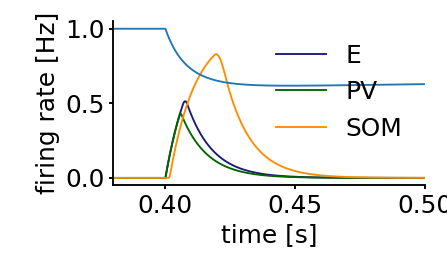

In [65]:
%matplotlib notebook

#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r.T,savetitle='rates_positive')

plt.plot(t,g)
save_fig(figure_directory, "all_activities_g")
plt.xlim([0.38,0.5])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup")

<IPython.core.display.Javascript object>


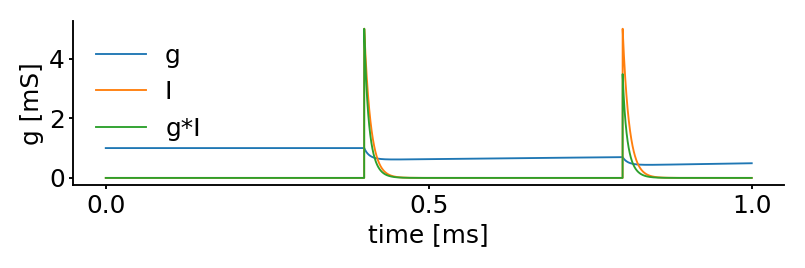

In [62]:
%matplotlib notebook
figsize=(9, 3)
ylabel = "g [mS]"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,g, label='g ')
plt.plot(t,I, label='I ')
plt.plot(t,g*I, label='g*I')
#plt.legend()
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize, frameon = False,loc = 'upper left')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "inputs_g_i_gi")

<IPython.core.display.Javascript object>


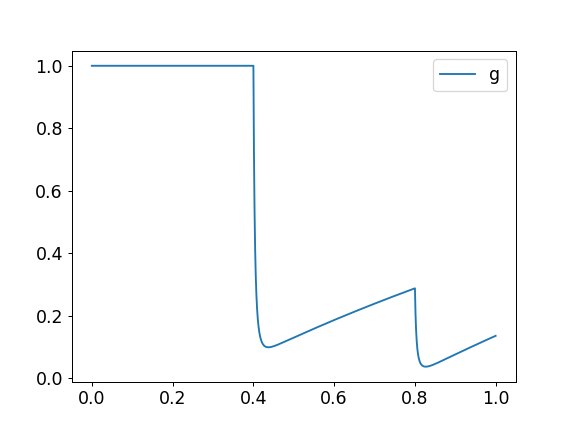

In [10]:
%matplotlib notebook
plt.plot(t,g, label='g')
# plt.plot(t,I, label='I')
# plt.plot(t,g*I, label='gI')
plt.legend()

In [ ]:
for i in range(len(t)-1):
    drdt = (np.dot(W,r[:,i])-r[:,i] + q*mu[:,i] - thr)/taus

In [ ]:
def f(x, al = 3):
    return al*np.heaviside(x,1)*x*np.heaviside(1/al-x,1)+np.heaviside(x-1/al,1)
# dan(x)=exp(-tl*x)
# p al = 3


In [ ]:
x = np.linspace(-5,5,100)
ff = f(x)

In [ ]:
%matplotlib notebook
plt.plot(x,ff)

# Plotting

<IPython.core.display.Javascript object>


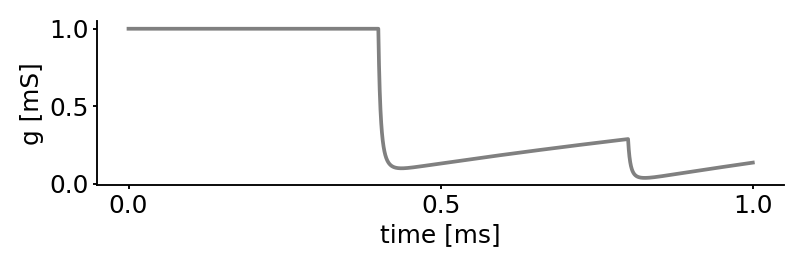

In [11]:
%matplotlib notebook
figsize=(9, 3)
ylabel = "g [mS]"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,g, lw = 3, c = "grey", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "g_input")

<IPython.core.display.Javascript object>


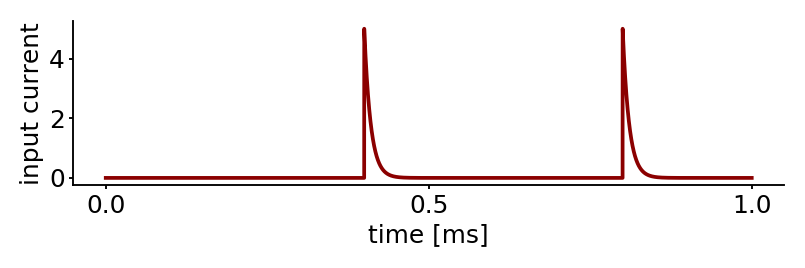

In [12]:
%matplotlib notebook
figsize=(9, 3)
ylabel = r"input current"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,I, lw = 3, c = "darkred", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "input_current")

<IPython.core.display.Javascript object>


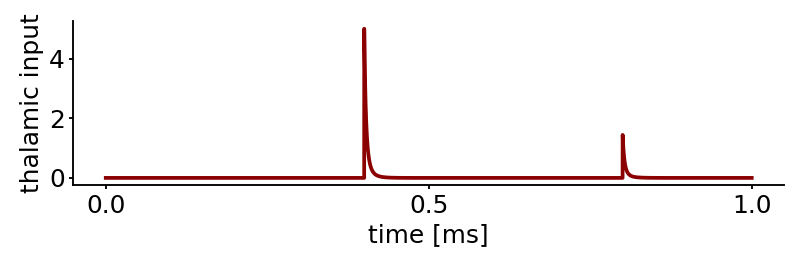

In [13]:
%matplotlib notebook
figsize=(9, 3)
ylabel = r"thalamic input"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,thalamic_input, lw = 3, c = "darkred", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "input_current")

<IPython.core.display.Javascript object>


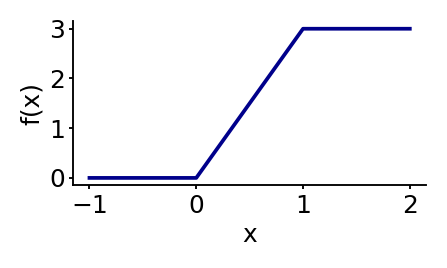

In [14]:
figsize=(5, 3)
ylabel = r"f(x)"
xlabel =r"x"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(x,x_nl, lw = 3, c = "darkblue", label="k = 10")
# for i in range(len(r0)):
#     plt.plot(t,r[:,i],label=labels[i])
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "nonlinearity_xy")


### Adaptation network

In [ ]:
# adaptation variables
T_adapt = np.array([[1.5, 1.5],[0.02, 0.02]])
g0 = np.ones(2)*10

thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.1
opto_onset = 5

y0 = np.hstack((np.zeros(3),g0))

r = integrate.odeint(network_TC_adapt, y0, t, args=(W, tau_neurons, T_adapt, g0))
plt.figure(figsize=(8,6))
plot_rates(t,r[:,:3]+r0, W)
plt.figure(figsize=(8,3))
plt.plot(t,r[:,3:])
plt.title('Adaptation Variables')

In [ ]:
def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.02, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        print(dgdt)
        g[i+1] = g[i] + dgdt*dt
    return g

In [ ]:
gg = thalamic_adaptation(I, t)